In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

from small_susc import make_layout_small_susc

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

import superscreen as sc

In [59]:
device = make_layout_small_susc()

In [60]:
device

Device(
    "susceptometer_100nm", 
    layers=[
        Layer("W2", Lambda=0.032, thickness=0.200, london_lambda=0.080, z0=0.100), 
        Layer("W1", Lambda=0.064, thickness=0.100, london_lambda=0.080, z0=0.380), 
        Layer("BE", Lambda=0.040, thickness=0.160, london_lambda=0.080, z0=0.660),
    ], 
    films=[
        Polygon("fc", layer="BE", points=ndarray[shape=(27, 2)]), 
        Polygon("pl_shield2", layer="BE", points=ndarray[shape=(6, 2)]), 
        Polygon("fc_shield", layer="W1", points=ndarray[shape=(10, 2)]), 
        Polygon("pl", layer="W1", points=ndarray[shape=(19, 2)]), 
        Polygon("pl_shield", layer="W2", points=ndarray[shape=(6, 2)]),
    ], 
    holes=[
        Polygon("fc_center", layer="BE", points=ndarray[shape=(28, 2)]),
    ], 
    abstract_regions=[
        Polygon("bounding_box", layer="BE", points=ndarray[shape=(4, 2)]), 
        Polygon("pl_hull", layer="W1", points=ndarray[shape=(12, 2)]),
    ], 
    length_units="um",
)

In [133]:
device = make_layout_small_susc()
device.layers["BE"].london_lambda = 1

# layers = device.layers
# layers["sample_layer"] = sc.Layer("sample_layer", Lambda=0.08, z0=0.05)

# films = device.films
# films["sample"] = sc.Polygon(
#     "sample",
#     layer="sample_layer",
#     points=device.abstract_regions["bounding_box"].points * 0.9,
# )

# device.layers = layers
# device.films = films

device.make_mesh(min_triangles=8000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8828 triangles.
INFO:superscreen.device:Finished generating mesh with 4536 points and 8828 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


In [134]:
device

Device(
    "susceptometer_100nm", 
    layers=[
        Layer("W2", Lambda=0.032, thickness=0.200, london_lambda=0.080, z0=0.100), 
        Layer("W1", Lambda=0.064, thickness=0.100, london_lambda=0.080, z0=0.380), 
        Layer("BE", Lambda=6.250, thickness=0.160, london_lambda=1.000, z0=0.660), 
        Layer("sample_layer", Lambda=0.080, thickness=None, london_lambda=None, z0=0.050),
    ], 
    films=[
        Polygon("fc", layer="BE", points=ndarray[shape=(27, 2)]), 
        Polygon("pl_shield2", layer="BE", points=ndarray[shape=(6, 2)]), 
        Polygon("fc_shield", layer="W1", points=ndarray[shape=(10, 2)]), 
        Polygon("pl", layer="W1", points=ndarray[shape=(19, 2)]), 
        Polygon("pl_shield", layer="W2", points=ndarray[shape=(6, 2)]), 
        Polygon("sample", layer="sample_layer", points=ndarray[shape=(4, 2)]),
    ], 
    holes=[
        Polygon("fc_center", layer="BE", points=ndarray[shape=(28, 2)]),
    ], 
    abstract_regions=[
        Polygon("bounding_box"

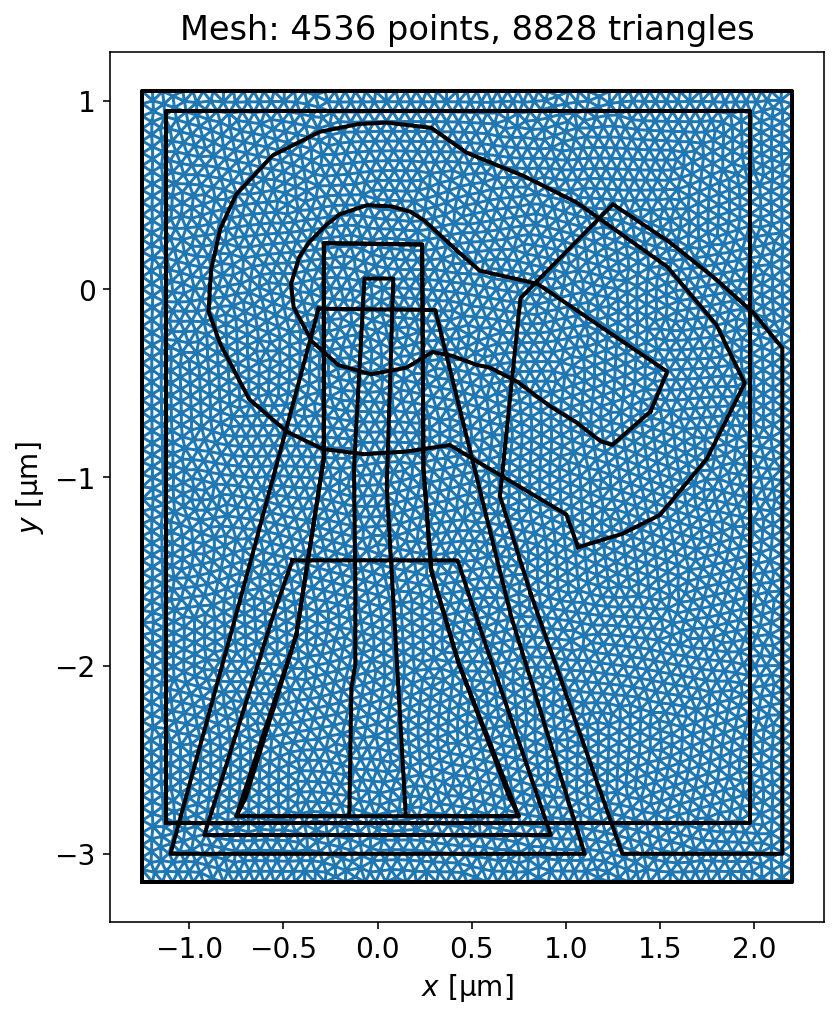

In [135]:
ax = device.plot_mesh()
ax = device.plot_polygons(ax=ax, color='k', lw=2, legend=False)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [136]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=5,
    coupled=True,
)

INFO:superscreen.brandt:Calculating W2 response to applied field.
INFO:superscreen.brandt:Calculating W1 response to applied field.
INFO:superscreen.brandt:Calculating BE response to applied field.
INFO:superscreen.brandt:Calculating sample_layer response to applied field.
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (1/5).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (1/5).
INFO:superscreen.brandt:Calculating screening field at W2 from sample_layer (1/5).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (1/5).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (1/5).
INFO:superscreen.brandt:Calculating screening field at W1 from sample_layer (1/5).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (1/5).
INFO:superscreen.brandt:Calculating screening field at BE from W1 (1/5).
INFO:superscreen.brandt:Calculating screening field at BE from sample_layer (1/5).
INFO:superscreen.brandt:Calculating scr

In [137]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
    
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [138]:
display(df)

,fc,pl_shield2,fc_shield,pl,pl_shield,sample,fc_center,bounding_box,pl_hull
Iteration,,,,,,,,,
0,2.584577,0.000000,0.000000,0.000000,0.000000,0.000000,2.084785,0.778054,0.000000
1,2.584577,0.000000,0.040999,0.031297,0.010580,0.048666,2.084785,0.778054,0.071913
2,2.480475,0.003703,0.032280,0.024346,0.015017,0.045110,2.036449,0.672003,0.053496
3,2.489747,0.001359,0.034043,0.023451,0.014299,0.045999,2.040376,0.678488,0.051037
4,2.487984,0.001903,0.033668,0.023679,0.014528,0.045811,2.039685,0.677078,0.051695
5,2.488295,0.001754,0.033749,0.023607,0.014481,0.045860,2.039801,0.677294,0.051485


<ipython-input-139-caf1db917f84>:5: RuntimeWarning: divide by zero encountered in true_divide
  ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]


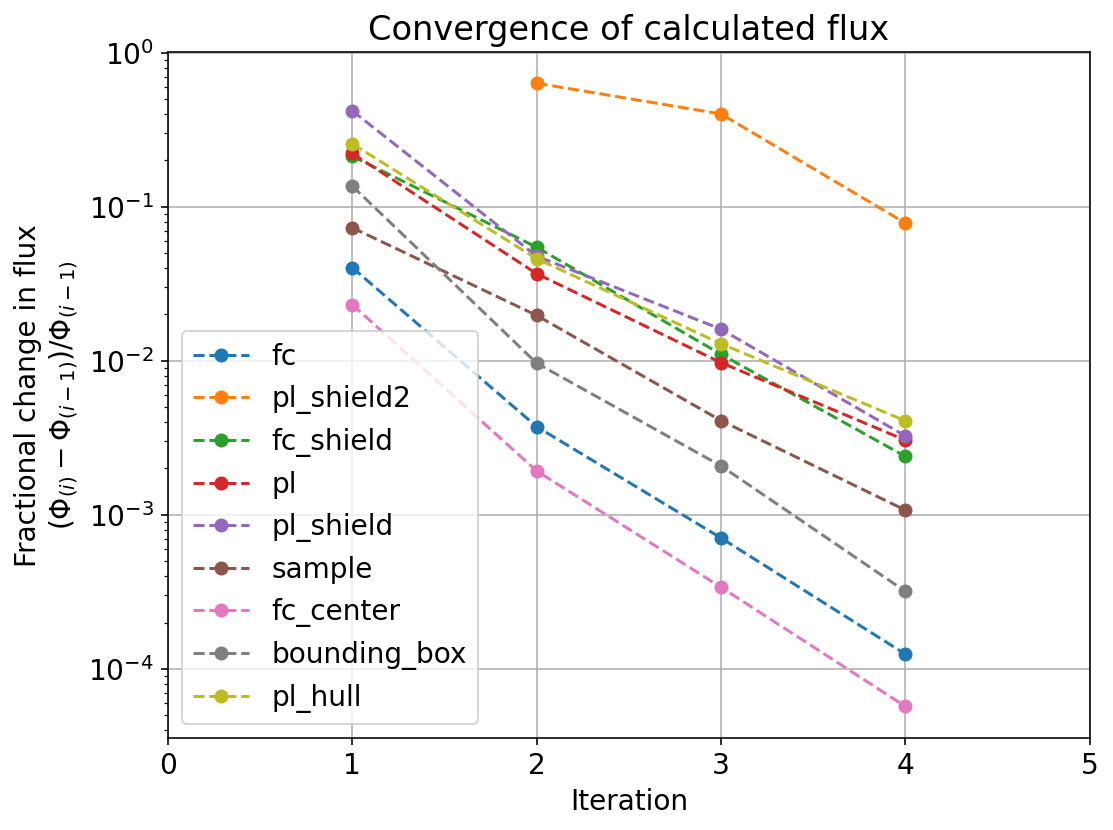

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} - \\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_yscale("log")
ax.set_xticks(range(len(df)))
ax.legend(loc=0)
ax.set_title("Convergence of calculated flux")
fig.tight_layout()

In [140]:
flux = solutions[-1].polygon_flux()
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(f"{(flux['pl_hull'] / device.ureg(circulating_currents['fc_center'])).to('Phi_0/A'):.3f~P}")

5.148×10⁻² Φ_0
51.485 Φ_0/A


In [141]:
flux = solutions[-1].polygon_flux()
I_circ = device.ureg(circulating_currents['fc_center'])
# print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"Calculated FC - PL mutual inductance:"
    f"\n\t{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

Calculated FC - PL mutual inductance:
	51.485 Φ_0/A = 0.106 pH


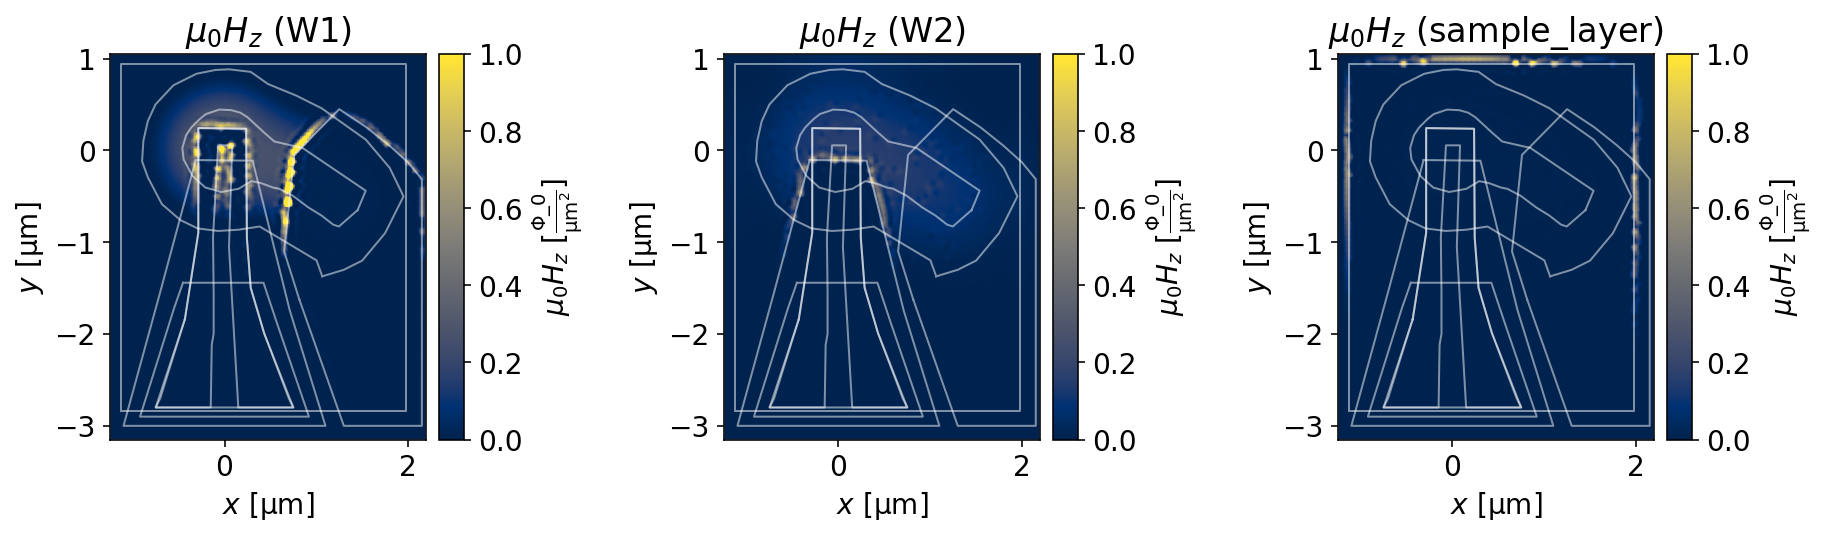

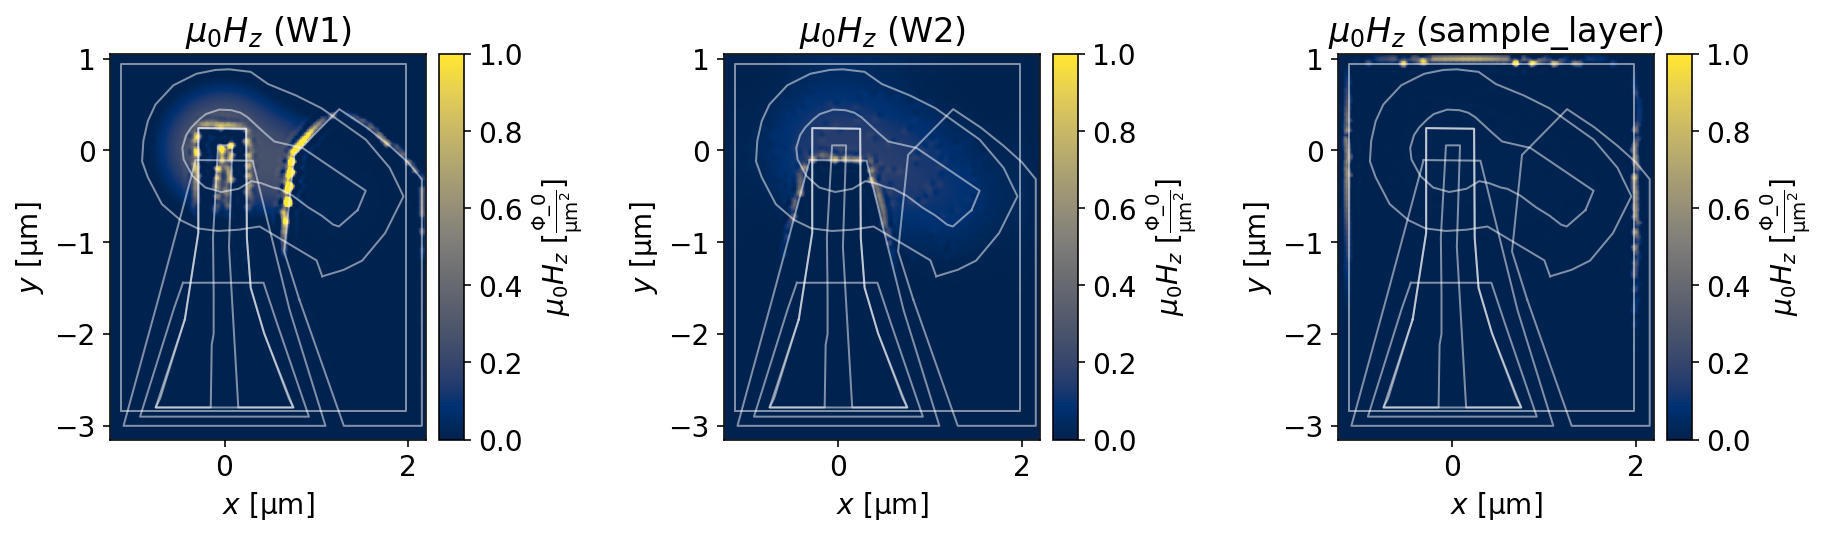

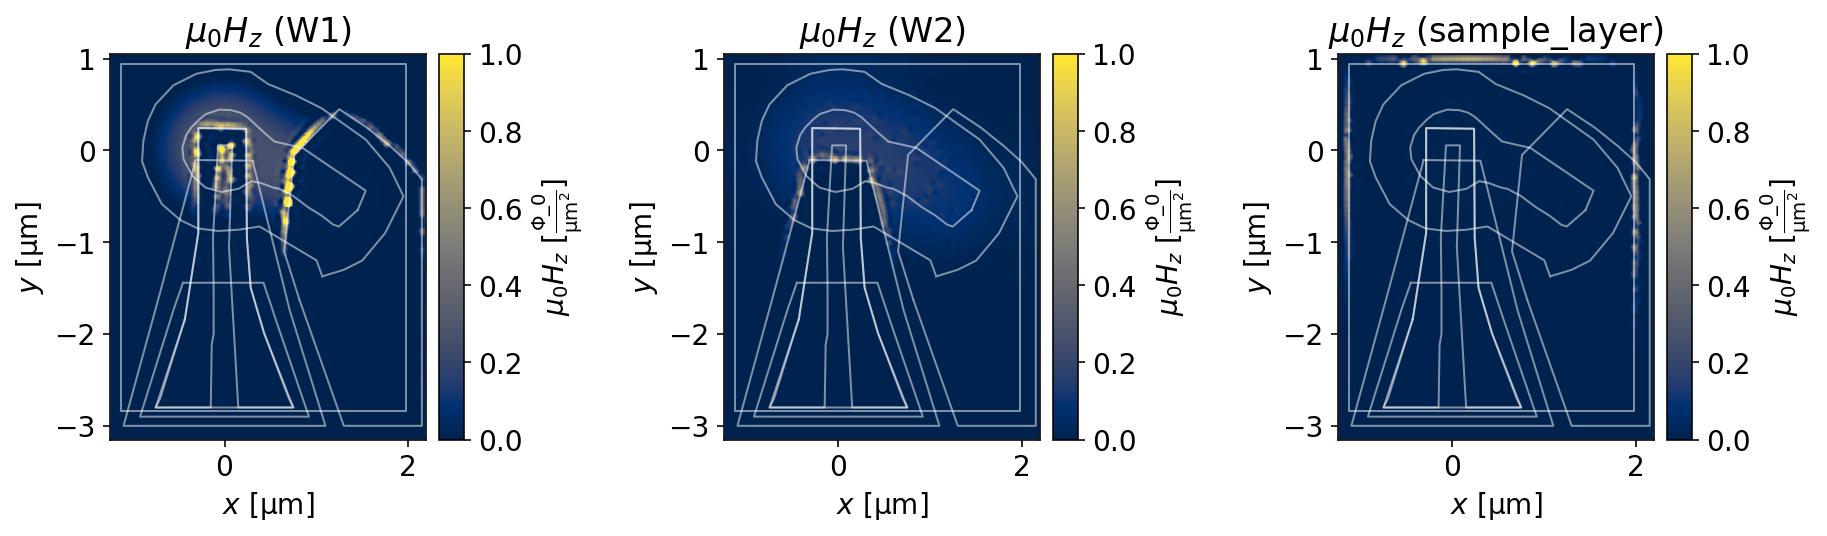

In [142]:
for solution in solutions[-3:]:
    fig, axes = sc.plot_fields(
        solution,
        grid_shape=500,
        layers=["W1", "W2", "sample_layer"],
        figsize=(13,4),
        vmin=0, vmax=1,
#         symmetric_color_scale=True,
        cmap="cividis",
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=1, alpha=0.5)

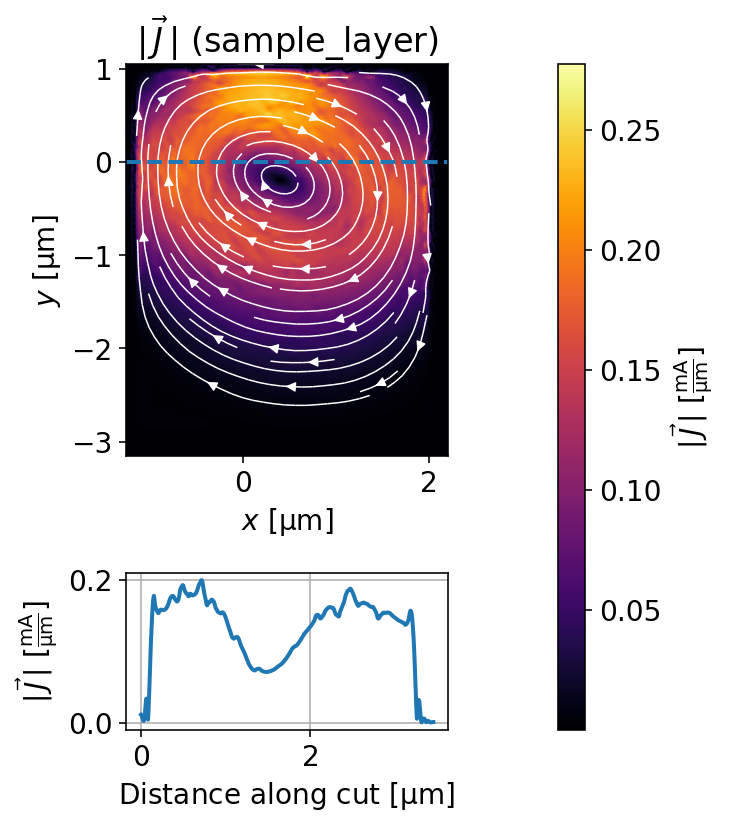

In [143]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_currents(
        solution,
        grid_shape=(500,500),
        layers=["sample_layer"],
        max_cols=4,
        figsize=(6,6),
        streamplot=True,
        units="mA/um",
        cross_section_ys=0,
        cross_section_angle=0,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=1, alpha=0)